# Code to Generate a Double Clustering of a UMAP Projection

Imports and Constants

**Part 1:** Loading Data

**Part 2:** Clustering

**Part 3:** Most Meningful Data Search

This provides a way to generate useful plots of the data and its secondary clustering.

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import hdbscan
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
from sklearn.cluster import DBSCAN
import umap
from collections import defaultdict

RESNET_VERSION = 50
LATENT_SPACE_DIM = 3
WINDOW_SIZE = 1
TRAINING_STEPS = 90
TRAIN_TEST_SPLIT = 0.1
LINE_WIDTH = 1

CLUSTER_SIZE = 3
SAMPLE_MIN = 2

MODEL_DIRECTORY = r'../Model_Generation/models'
IMAGES_DIRECTORY = r'../BandData/Images'

SEED = 42
np.random.seed(SEED)



## Part 1: Loading Data

In [2]:
path = Path("../explorer/fingerprints")
model = f"resnet{RESNET_VERSION}_latent{LATENT_SPACE_DIM}_window{WINDOW_SIZE}eV_steps{TRAINING_STEPS}_split{TRAIN_TEST_SPLIT * 10}_width{LINE_WIDTH}_.csv"
model_path = path / model

csv = pd.read_csv(model_path)

features = csv.filter(like="z").to_numpy()


model_embed = f"resnet{RESNET_VERSION}_latent{LATENT_SPACE_DIM}_window{WINDOW_SIZE}eV_steps{TRAINING_STEPS}_split{TRAIN_TEST_SPLIT * 10}_width{LINE_WIDTH}_embedding.csv"
model_path_embed = path / model_embed

csv_embed = pd.read_csv(model_path_embed)

embedding = csv_embed.filter(like="z").to_numpy()

## Part 2: Clustering

In [3]:
# initial clustering
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=CLUSTER_SIZE,
    min_samples=SAMPLE_MIN,
    metric="minkowski",
    cluster_selection_method="leaf",
    p=0.2,
    core_dist_n_jobs=-1
)
hdbscan_labels = clusterer.fit_predict(features)


# DBSCAN on non noised
mask = (hdbscan_labels != -1)
masked_features = features[mask]
masked_embedding = embedding[mask]

dbscan = DBSCAN(eps=0.8, min_samples=5)
dbscan_labels = dbscan.fit_predict(masked_embedding)



/home/justin/miniconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/justin/miniconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Showing full figure

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl

def get_spaced_colors(n, seed=42):
    """Generate n well-separated colors with a fixed seed."""
    np.random.seed(seed)
    cmap = plt.get_cmap('tab20', n)
    colors = cmap(np.arange(n))
    np.random.shuffle(colors)
    return colors


Noise: 299
Meaningful data: 247


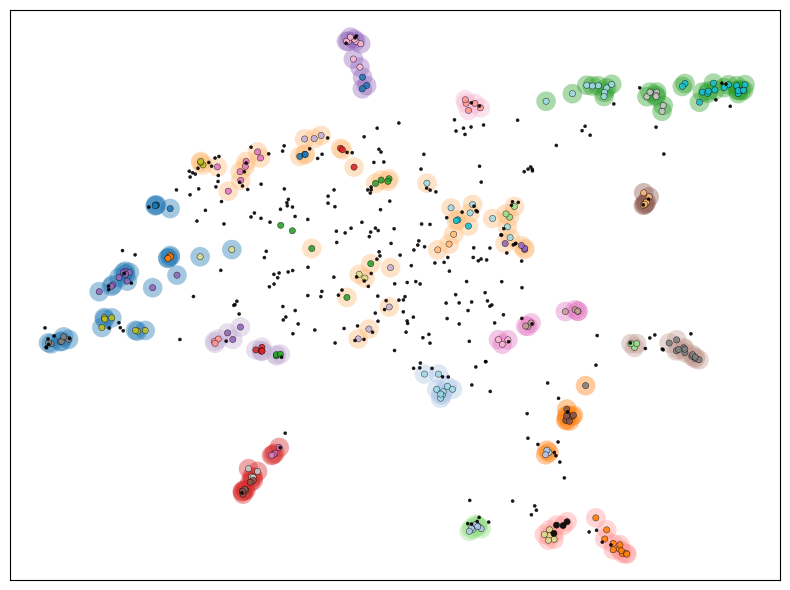

In [31]:
# Foreground: HDBSCAN (with -1 = black)
main_labels = np.unique(hdbscan_labels)
n_clusters_1 = len(main_labels) - (1 if -1 in main_labels else 0)
hdbscan_colors = get_spaced_colors(n_clusters_1)
colors_1 = np.vstack([[0, 0, 0, 1], hdbscan_colors])  # Prepend black for noise = -1
cmap_1 = ListedColormap(colors_1)

# Background: DBSCAN (ignore -1)
valid_mask = (dbscan_labels != -1)
valid_dbscan_labels = dbscan_labels[valid_mask]
valid_embedding = masked_embedding[valid_mask]
n_clusters_2 = len(np.unique(valid_dbscan_labels))
colors_2 = list(plt.cm.tab20.colors[:n_clusters_2])
cmap_2 = ListedColormap(colors_2)


valid_mask2 = (hdbscan_labels != -1)
valid_hdbscan_labels = hdbscan_labels[valid_mask2]
valid_hdbscan_embedding = embedding[valid_mask2]

non_valid_mask = (hdbscan_labels == -1)
non_valid_hdbscan_labels = hdbscan_labels[non_valid_mask]
non_valid_embedding = embedding[non_valid_mask]
print('Noise:', len(non_valid_hdbscan_labels))
print('Meaningful data:', len(valid_hdbscan_labels))

# ---- Plotting ----
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xticks([])
ax.set_yticks([])

# Background DBSCAN clustering (faint)
ax.scatter(
    valid_embedding[:, 0],
    valid_embedding[:, 1],
    c=valid_dbscan_labels,
    cmap=cmap_2,
    s=200,
    alpha=0.4,
    linewidths=0
)

# Foreground HDBSCAN clustering (solid)
ax.scatter(
    valid_hdbscan_embedding[:, 0],
    valid_hdbscan_embedding[:, 1],
    c=valid_hdbscan_labels,
    cmap=cmap_1,
    s=20,
    alpha=0.9,
    edgecolor='k',
    linewidth=0.3
)

black_cmap = mcolors.ListedColormap(['black'])
ax.scatter(
    non_valid_embedding[:, 0],
    non_valid_embedding[:, 1],
    c=non_valid_hdbscan_labels,
    cmap=black_cmap,
    s=5,
    alpha=0.9,
    edgecolor='k',
    linewidth=0.3
)




plt.tight_layout()
fig.savefig("../Figures/BestModelClustered.png", dpi=300, bbox_inches='tight')


Removing noise

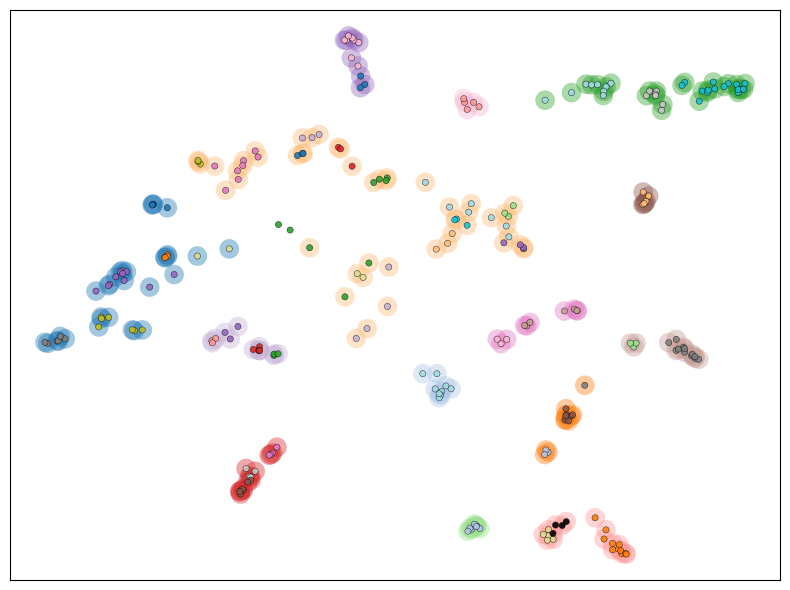

In [32]:
# Foreground: HDBSCAN (with -1 = black)
main_labels = np.unique(hdbscan_labels)
n_clusters_1 = len(main_labels) - (1 if -1 in main_labels else 0)
colors_1 = np.vstack([[0, 0, 0, 1], hdbscan_colors])  # Prepend black for noise = -1
cmap_1 = ListedColormap(colors_1)

# Background: DBSCAN (ignore -1)
valid_mask = (dbscan_labels != -1)
valid_dbscan_labels = dbscan_labels[valid_mask]
valid_embedding = masked_embedding[valid_mask]
n_clusters_2 = len(np.unique(valid_dbscan_labels))
colors_2 = list(plt.cm.tab20.colors[:n_clusters_2])
cmap_2 = ListedColormap(colors_2)


valid_mask2 = (hdbscan_labels != -1)
valid_hdbscan_labels = hdbscan_labels[valid_mask2]
valid_hdbscan_embedding = embedding[valid_mask2]

non_valid_mask = (hdbscan_labels == -1)
non_valid_hdbscan_labels = hdbscan_labels[non_valid_mask]
non_valid_embedding = embedding[non_valid_mask]


# ---- Plotting ----
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xticks([])
ax.set_yticks([])

# Background DBSCAN clustering (faint)
ax.scatter(
    valid_embedding[:, 0],
    valid_embedding[:, 1],
    c=valid_dbscan_labels,
    cmap=cmap_2,
    s=200,
    alpha=0.4,
    linewidths=0
)

# Foreground HDBSCAN clustering (solid)
ax.scatter(
    valid_hdbscan_embedding[:, 0],
    valid_hdbscan_embedding[:, 1],
    c=valid_hdbscan_labels,
    cmap=cmap_1,
    s=20,
    alpha=0.9,
    edgecolor='k',
    linewidth=0.3
)


plt.tight_layout()
plt.show()
fig.savefig("../Figures/BestModelClustered_NoNoise.png", dpi=300, bbox_inches='tight')


Only showing second clustering

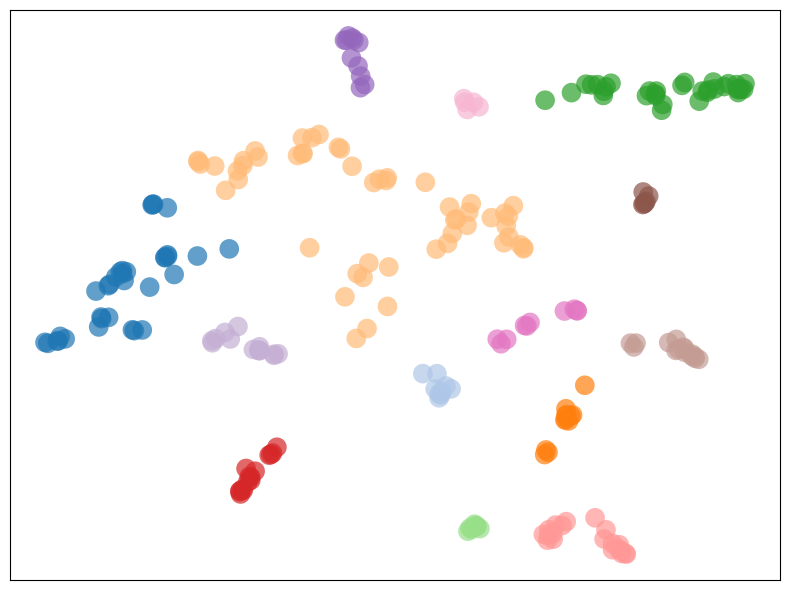

In [33]:
# Foreground: HDBSCAN (with -1 = black)
main_labels = np.unique(hdbscan_labels)
n_clusters_1 = len(main_labels) - (1 if -1 in main_labels else 0)
colors_1 = np.vstack([[0, 0, 0, 1], hdbscan_colors])  # Prepend black for noise = -1
cmap_1 = ListedColormap(colors_1)

# Background: DBSCAN (ignore -1)
valid_mask = (dbscan_labels != -1)
valid_dbscan_labels = dbscan_labels[valid_mask]
valid_embedding = masked_embedding[valid_mask]
n_clusters_2 = len(np.unique(valid_dbscan_labels))
colors_2 = list(plt.cm.tab20.colors[:n_clusters_2])
cmap_2 = ListedColormap(colors_2)


valid_mask2 = (hdbscan_labels != -1)
valid_hdbscan_labels = hdbscan_labels[valid_mask2]
valid_hdbscan_embedding = embedding[valid_mask2]

non_valid_mask = (hdbscan_labels == -1)
non_valid_hdbscan_labels = hdbscan_labels[non_valid_mask]
non_valid_embedding = embedding[non_valid_mask]


# ---- Plotting ----
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xticks([])
ax.set_yticks([])

# Background DBSCAN clustering (faint)
ax.scatter(
    valid_embedding[:, 0],
    valid_embedding[:, 1],
    c=valid_dbscan_labels,
    cmap=cmap_2,
    s=200,
    alpha=0.7,
    linewidths=0
)


plt.tight_layout()
plt.show()
fig.savefig("../Figures/BestModelClustered_OnlyDBSCAN.png", dpi=300, bbox_inches='tight')


Labeling key points

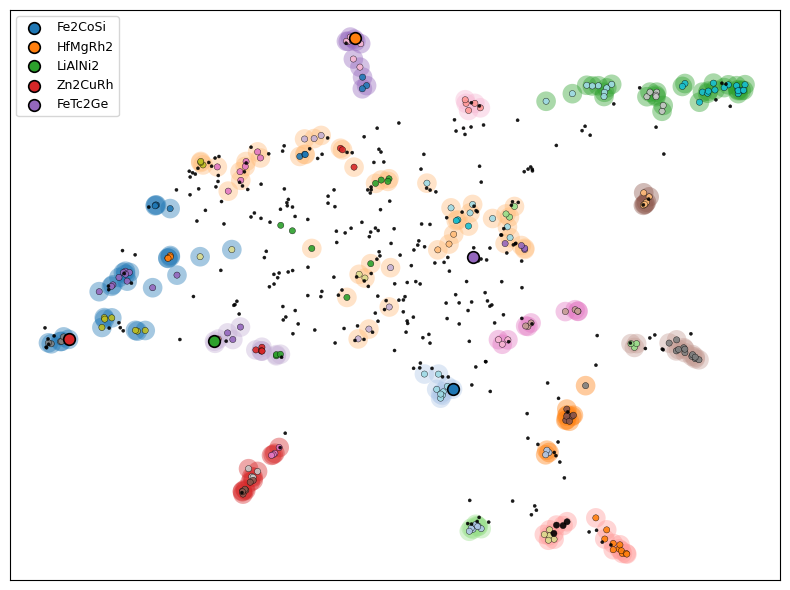

In [34]:
# Foreground: HDBSCAN (with -1 = black)
main_labels = np.unique(hdbscan_labels)
n_clusters_1 = len(main_labels) - (1 if -1 in main_labels else 0)
colors_1 = np.vstack([[0, 0, 0, 1], hdbscan_colors])  # Prepend black for noise = -1
cmap_1 = ListedColormap(colors_1)

# Background: DBSCAN (ignore -1)
valid_mask = (dbscan_labels != -1)
valid_dbscan_labels = dbscan_labels[valid_mask]
valid_embedding = masked_embedding[valid_mask]
n_clusters_2 = len(np.unique(valid_dbscan_labels))
colors_2 = list(plt.cm.tab20.colors[:n_clusters_2])
cmap_2 = ListedColormap(colors_2)


valid_mask2 = (hdbscan_labels != -1)
valid_hdbscan_labels = hdbscan_labels[valid_mask2]
valid_hdbscan_embedding = embedding[valid_mask2]

non_valid_mask = (hdbscan_labels == -1)
non_valid_hdbscan_labels = hdbscan_labels[non_valid_mask]
non_valid_embedding = embedding[non_valid_mask]


# ---- Plotting ----
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xticks([])
ax.set_yticks([])

# Background DBSCAN clustering (faint)
ax.scatter(
    valid_embedding[:, 0],
    valid_embedding[:, 1],
    c=valid_dbscan_labels,
    cmap=cmap_2,
    s=200,
    alpha=0.4,
    linewidths=0
)

# Foreground HDBSCAN clustering (solid)
ax.scatter(
    valid_hdbscan_embedding[:, 0],
    valid_hdbscan_embedding[:, 1],
    c=valid_hdbscan_labels,
    cmap=cmap_1,
    s=20,
    alpha=0.9,
    edgecolor='k',
    linewidth=0.3
)

black_cmap = mcolors.ListedColormap(['black'])
ax.scatter(
    non_valid_embedding[:, 0],
    non_valid_embedding[:, 1],
    c=non_valid_hdbscan_labels,
    cmap=black_cmap,
    s=5,
    alpha=0.9,
    edgecolor='k',
    linewidth=0.3
)

from itertools import cycle

# Define molecule names to highlight
molecule_names_to_highlight = ['Fe2CoSi.png', 'HfMgRh2.png', 'LiAlNi2.png', 'Zn2CuRh.png', 'FeTc2Ge.png']  # Replace with your choices
colors = cycle(plt.cm.tab10.colors)  # or use any custom list of colors

# Define list of molecule names to highlight
highlight_mask = csv.iloc[:, 0].isin(molecule_names_to_highlight)
highlight_coords = embedding[highlight_mask]

for name, color in zip(molecule_names_to_highlight, colors):
    # Find row(s) corresponding to this molecule
    match_mask = csv.iloc[:, 0] == name
    coords = embedding[match_mask]

    name = name.split('.')[0]
    # Plot with unique color
    ax.scatter(
        coords[:, 0],
        coords[:, 1],
        s=70,
        c=[color],
        edgecolor='black',
        linewidth=1.2,
        label=name
    )

# Add legend
ax.legend(loc='upper left', fontsize=9)



plt.tight_layout()
plt.show()
fig.savefig("../Figures/BestModelClustered_KeyPointFinder.png", dpi=300, bbox_inches='tight')


## Part 3: Most Meaningful Data Search

Using the HDBSCAN 'probabilities' value, we can find the point in a cluster which is the most 'likey' to be in the cluster, that is its core. Here we label them.

In [8]:
# initial clustering
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=CLUSTER_SIZE,
    min_samples=SAMPLE_MIN,
    metric="minkowski",
    cluster_selection_method="leaf",
    p=0.2,
    core_dist_n_jobs=-1
)
hdbscan_labels = clusterer.fit_predict(features)
probabilities = clusterer.probabilities_

data = list(zip(hdbscan_labels, probabilities))

max_info = {}  # key: first value, value: (max_val, index)

for idx, (key, val) in enumerate(data):
    if key not in max_info or val > max_info[key][0]:
        max_info[key] = (val, idx)

# Print the result
for key, (val, idx) in sorted(max_info.items()):
    print(f"Key {key + 1}: max value = {val}, {csv.iloc[idx]['filename']}")
    
highlight_idxs = [idx for (_, idx) in max_info.values()]
highlight_coords = embedding[highlight_idxs]


Key 0: max value = 0.0, Ac2HgGe.png
Key 1: max value = 1.0, MgScCd2.png
Key 2: max value = 1.0, ScAlAu2.png
Key 3: max value = 1.0, MgSc2Tl.png
Key 4: max value = 1.0, Sc2AlZn.png
Key 5: max value = 1.0, Sc2AgOs.png
Key 6: max value = 1.0, HfAlRh2.png
Key 7: max value = 1.0, MgAlPd2.png
Key 8: max value = 1.0, Mg2AgHg.png
Key 9: max value = 1.0, MgZrPd2.png
Key 10: max value = 1.0, HfInCo2.png
Key 11: max value = 1.0, CaCdHg2.png
Key 12: max value = 1.0, ScCdAg2.png
Key 13: max value = 1.0, Cd2AgAu.png
Key 14: max value = 1.0, HfZnNi2.png
Key 15: max value = 1.0, HfZnIr2.png
Key 16: max value = 1.0, LiAlNi2.png
Key 17: max value = 1.0, Hf2CuTc.png
Key 18: max value = 1.0, Al2CoIr.png
Key 19: max value = 1.0, HfSnRu2.png
Key 20: max value = 1.0, HfGeRu2.png
Key 21: max value = 1.0, Nb2TcRu.png
Key 22: max value = 1.0, Al2IrRh.png
Key 23: max value = 1.0, ScAlRh2.png
Key 24: max value = 1.0, Sc2NiRu.png
Key 25: max value = 1.0, Mn2NbAl.png
Key 26: max value = 1.0, NbTc2Ge.png
Key 27: max

/home/justin/miniconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/justin/miniconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


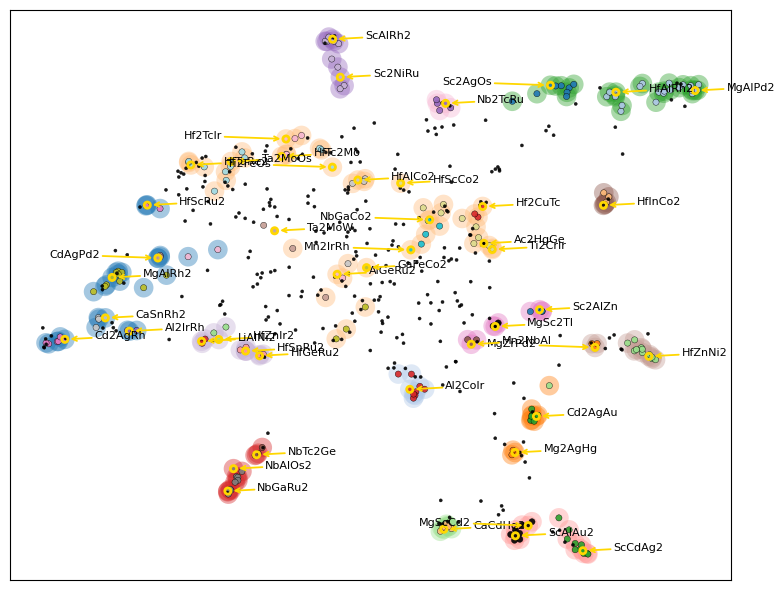

In [9]:
# Foreground: HDBSCAN (with -1 = black)
main_labels = np.unique(hdbscan_labels)
n_clusters_1 = len(main_labels) - (1 if -1 in main_labels else 0)
colors_1 = ['black'] + list(plt.cm.tab20.colors[:n_clusters_1])
cmap_1 = ListedColormap(colors_1)

# Background: DBSCAN (ignore -1)
valid_mask = (dbscan_labels != -1)
valid_dbscan_labels = dbscan_labels[valid_mask]
valid_embedding = masked_embedding[valid_mask]
n_clusters_2 = len(np.unique(valid_dbscan_labels))
colors_2 = list(plt.cm.tab20.colors[:n_clusters_2])
cmap_2 = ListedColormap(colors_2)


valid_mask2 = (hdbscan_labels != -1)
valid_hdbscan_labels = hdbscan_labels[valid_mask2]
valid_hdbscan_embedding = embedding[valid_mask2]

non_valid_mask = (hdbscan_labels == -1)
non_valid_hdbscan_labels = hdbscan_labels[non_valid_mask]
non_valid_embedding = embedding[non_valid_mask]


# ---- Plotting ----
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xticks([])
ax.set_yticks([])

# Background DBSCAN clustering (faint)
ax.scatter(
    valid_embedding[:, 0],
    valid_embedding[:, 1],
    c=valid_dbscan_labels,
    cmap=cmap_2,
    s=200,
    alpha=0.4,
    linewidths=0
)

# Foreground HDBSCAN clustering (solid)
ax.scatter(
    valid_hdbscan_embedding[:, 0],
    valid_hdbscan_embedding[:, 1],
    c=valid_hdbscan_labels,
    cmap=cmap_1,
    s=20,
    alpha=0.9,
    edgecolor='k',
    linewidth=0.3
)

black_cmap = mcolors.ListedColormap(['black'])
ax.scatter(
    non_valid_embedding[:, 0],
    non_valid_embedding[:, 1],
    c=non_valid_hdbscan_labels,
    cmap=black_cmap,
    s=5,
    alpha=0.9,
    edgecolor='k',
    linewidth=0.3
)

# Gold outline
ax.scatter(
    highlight_coords[:, 0],
    highlight_coords[:, 1],
    s=20,
    facecolors='none',
    edgecolors='gold',
    linewidths=2,
    label="Cluster Exemplars"
)

# Annotate each one with its filename
from scipy.spatial import cKDTree

coords = embedding
tree = cKDTree(coords)

# Candidate offsets: (dx, dy)
offsets = [
    (40, 0),    # right
    (-60, 0),   # left
    (0, 40),    # up
    (0, -40),   # down
    (30, 30),   # up-right
    (-30, 30),  # up-left
    (30, -30),  # down-right
    (-30, -30), # down-left
]

for idx in highlight_idxs:
    filename = csv.iloc[idx]['filename'].split('.')[0]
    x, y = embedding[idx]

    best_offset = (40, 0)
    min_density = float('inf')

    # Test each offset
    for dx, dy in offsets:
        tx, ty = x + dx * 0.01, y + dy * 0.01  # scale offset for real distance
        count = len(tree.query_ball_point([tx, ty], r=0.1))  # count nearby points

        if count < min_density:
            min_density = count
            best_offset = (dx, dy)

    # Plot with chosen offset
    ax.annotate(
        filename,
        xy=(x, y),
        xytext=best_offset,
        textcoords='offset points',
        ha='center',
        fontsize=8,
        color='black',
        arrowprops=dict(
            arrowstyle='->',
            color='gold',
            lw=1.3,
            shrinkA=0,
            shrinkB=4
        )
    )




plt.tight_layout()
plt.show()
fig.savefig("../Figures/BestModelClustered_NotablePointsFinder.png", dpi=300, bbox_inches='tight')



